<a href="https://colab.research.google.com/github/ctclumak/posts/blob/master/Unsupervised_Clustering_Learning_Retail_Customers_RFM_Segmentation_and_KMeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_excel("/content/Online Retail.xlsx",dtype={"CustomerID":str, "InvoiceNo":str})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [5]:
print("Number of rows that net quantity is negative:",
      df[df.Quantity<0].shape[0])

Number of rows that net quantity is negative: 10624


In [6]:
#Exclude the returns from the database
df=df[df.Quantity>0]

In [7]:
df["TotalSpend"] = df.Quantity*df.UnitPrice

In [8]:
pd.DataFrame(df.groupby(["CustomerID", "Country"]).TotalSpend.sum().sort_values(ascending=False)).describe()

,TotalSpend
count,4347.000000
mean,2050.013320
std,8980.103578
min,0.000000
25%,307.430000
50%,671.960000
75%,1661.195000
max,280206.020000


In [9]:

pd.DataFrame(data=df.isnull().sum()/df.shape[0]*100,index=df.columns, columns=['% Null Values'])

,% Null Values
InvoiceNo,0.000000
StockCode,0.000000
Description,0.111428
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,25.101593
Country,0.000000
TotalSpend,0.000000


In [10]:
df[df.CustomerID.isnull()].TotalSpend.sum()/df.TotalSpend.sum()*100

16.28204877387241

In [11]:
df.dropna(subset=["CustomerID"],inplace=True)
df.shape

(397924, 9)

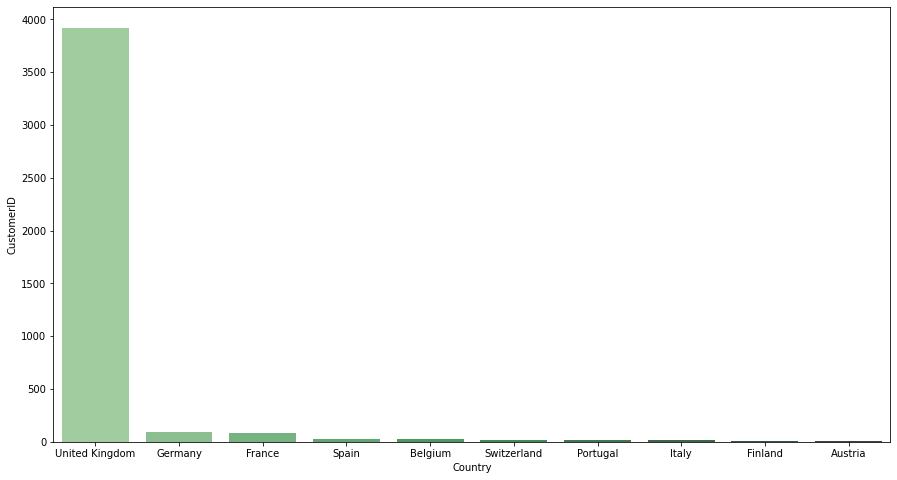

In [12]:
df_country=df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False).reset_index().head(10)
plt.figure(figsize=(15,8))
sns.barplot(data=df_country, x='Country', y='CustomerID',palette="Greens_d")


In [13]:
len(df.query('Country=="United Kingdom"'))/len(df)

0.8904841125441039

**RFM Analysis**

In [14]:
from datetime import datetime
df.InvoiceDate=df.InvoiceDate.dt.date

In [15]:
#Create date variable that records recency
snaptshot_date = max(df.InvoiceDate) + pd.Timedelta(days=1)

#Aggregate data by each customer
customers = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x : (snaptshot_date-x.max()).days,
    "InvoiceNo": "count",
    "TotalSpend": "sum"
})

#rename columns
customers.rename(columns={
                          'InvoiceDate': "Recency", 
                          "InvoiceNo": "Frequency",
                          "TotalSpend": "MonetaryValue"},inplace=True)

In [16]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


In [17]:
Avg_value = round(np.mean(customers.MonetaryValue),2)
Avg_freq = round(np.mean(customers.Frequency),2)
retention_rate = round(customers[customers.Frequency>1].shape[0]/customers.shape[0],2)
print(f"Average Monetary Value: ${Avg_value}")
print(f"Average Frequency: {Avg_freq}")
print(f"Retention Rate: {retention_rate}%")

Average Monetary Value: $2053.79
Average Frequency: 91.71
Retention Rate: 0.98%


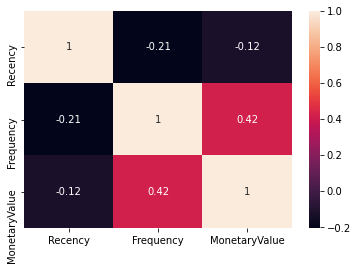

In [18]:
sns.heatmap(customers.corr(),annot=True)

## Manage Skewness

In [19]:
#We will apply Power Transformation to convert these features into a normal distribution
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
customers = pd.DataFrame(pt.fit_transform(customers))
customers.rename(columns={0: "Recency", 
                          1: "Frequency",
                          2: "MonetaryValue"},inplace=True)
customers.head()

,Recency,Frequency,MonetaryValue
0,1.614124,-2.420116,3.193082
1,-1.729289,1.178407,1.377477
2,0.307296,-0.219010,0.745038
3,-0.714932,0.451547,0.728345
4,1.567863,-0.677875,-0.592290


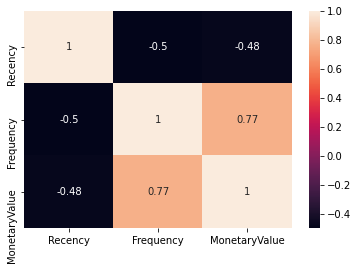

In [20]:
sns.heatmap(customers.corr(),annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

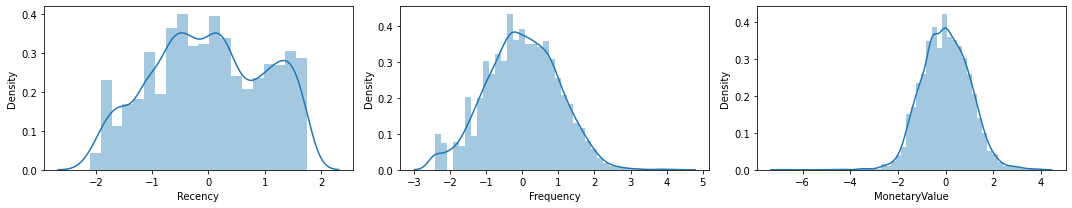

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'],ax=ax[0])
sns.distplot(customers["Frequency"],ax=ax[1])
sns.distplot(customers["MonetaryValue"],ax=ax[2])
plt.tight_layout()
plt.show()

# Normalization

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(customers))


,0,1,2
0,1.614124,-2.420116,3.193082
1,-1.729289,1.178407,1.377477
2,0.307296,-0.219010,0.745038
3,-0.714932,0.451547,0.728345
4,1.567863,-0.677875,-0.592290
...,...,...,...
4334,1.458820,-1.069762,-1.124451
4335,1.055919,-1.322743,-1.853628
4336,-1.243771,-0.936920,-1.137008
4337,-1.600575,2.323804,0.858842


##Compare Different Models

In [23]:
from sklearn.cluster import AgglomerativeClustering,KMeans, DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn.metrics import silhouette_score


cluster_agg= AgglomerativeClustering(n_clusters=2)

y_pred_agg = cluster_agg.fit_predict(customers)
silhouette_score(customers,cluster_agg.labels_)



0.3721993409101969

In [24]:
print("Unique labels: {}".format(np.unique(y_pred_agg)))

Unique labels: [0 1]


In [25]:
cluster_dbscan = DBSCAN()
y_pred_dbscan = cluster_dbscan.fit_predict(customers)

silhouette_score(customers,cluster_dbscan.labels_)

0.4707447629600436

In [26]:
print("Unique labels: {}".format(np.unique(y_pred_dbscan)))

Unique labels: [-1  0]


## Dimension Reduction - PCA

In [27]:
from sklearn.decomposition import PCA
pca = PCA()
pca_transformed = pca.fit_transform(customers)

In [28]:
pca.components_

array([[-0.50701994,  0.61193106,  0.60701826],
       [-0.86144462, -0.33601844, -0.38079494],
       [-0.02905092, -0.71598323,  0.69751276]])

# K-Means Clustering

##Finding the optimal number of clusters

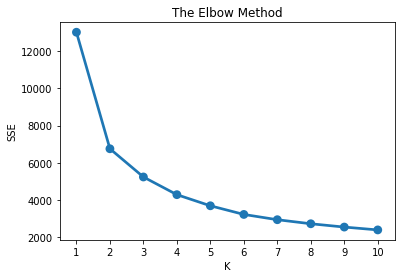

In [29]:
#modeling
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10).fit(customers)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
#inertia is the mean squared distance between each instance and its closest centroid


plt.title("The Elbow Method")
plt.xlabel('K')
plt.ylabel("SSE")
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Based on our observation, the k-value of 2 is the best hyperparameter for our model because the next k-value tend to have a linear trend.**

In [30]:
cluster=KMeans(n_clusters=2,random_state=42)
cluster.fit_transform(customers)
y_pred = cluster.fit_predict(customers)
y_pred.shape, cluster.labels_.shape
#The KMeans instance preserves a copy of the labels of the instances it was trained on, 
#available via the labels_ instance variable

((4339,), (4339,))

**The score() method returns the negative inertia. Why negative? Because a predictor’s score() method must
always respect Scikit-Learn’s “greater is better” rule: if a predictor is better than another, its score() method
should return a greater score.**

In [31]:
cluster.score(customers), print("Unique labels: {}".format(np.unique(y_pred)))

Unique labels: [0 1]


(-6750.088761618675, None)

## Model Evaludation - Silhousette Score

In [32]:
from sklearn.metrics import silhouette_score
silhouette_score(customers,cluster.labels_)

0.3969472752885103

## RFM Segmentations

In [33]:
recency_score = pd.qcut(customers.Recency, q=3,labels=range(1,4))
frequency_score = pd.qcut(customers.Frequency, q=3,labels=range(1,4))
monetary_score = pd.qcut(customers.MonetaryValue, q=3,labels=range(1,4))
customers=customers.assign(R=recency_score.values, F=frequency_score.values,M=monetary_score.values )
customers

,Recency,Frequency,MonetaryValue,R,F,M
0,1.614124,-2.420116,3.193082,3,1,3
1,-1.729289,1.178407,1.377477,1,3,3
2,0.307296,-0.219010,0.745038,2,2,3
3,-0.714932,0.451547,0.728345,1,2,3
4,1.567863,-0.677875,-0.592290,3,1,1
...,...,...,...,...,...,...
4334,1.458820,-1.069762,-1.124451,3,1,1
4335,1.055919,-1.322743,-1.853628,3,1,1
4336,-1.243771,-0.936920,-1.137008,1,1,1
4337,-1.600575,2.323804,0.858842,1,3,3


## RFM Score

In [34]:
def rfm_score(row):
  return str(row["R"]) + str(row["F"])+str(row["M"])
customers["RFM_Score"]=customers.apply(rfm_score,axis=1)
customers.sort_values("RFM_Score", ascending=False).head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
1936,0.661318,0.812077,0.677230,3,3,3,3.03.03.0
2715,0.690578,0.553137,0.523757,3,3,3,3.03.03.0
1297,1.318297,0.462303,0.480042,3,3,3,3.03.03.0
335,0.668714,0.676759,1.068596,3,3,3,3.03.03.0
1759,1.138362,0.608456,0.582468,3,3,3,3.03.03.0


In [35]:
customers.query('RFM_Score=="333"').sort_values("MonetaryValue", ascending=False)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score


In [36]:
df.query('CustomerID == "16180"').groupby("StockCode").sum().sort_values("Quantity", ascending=False)

,Quantity,UnitPrice,TotalSpend
StockCode,,,
23203,500,8.95,895.00
23199,500,8.95,895.00
23202,500,8.95,895.00
85099B,410,8.97,721.50
23200,400,7.16,716.00
...,...,...,...
23091,3,6.25,18.75
21754,3,5.95,17.85
21745,3,3.75,11.25


In [37]:
RFM_count=pd.DataFrame(customers.RFM_Score.value_counts()).reset_index().rename(columns = {"index":"RFM_Sore", "RFM_Score":"Count"})
RFM_count

,RFM_Sore,Count
0,1.03.03.0,692
1,3.01.01.0,643
2,2.03.03.0,339
3,2.02.02.0,339
4,2.01.01.0,289
5,3.02.02.0,275
6,1.02.02.0,238
7,1.01.01.0,167
8,3.01.02.0,147
9,3.02.01.0,134


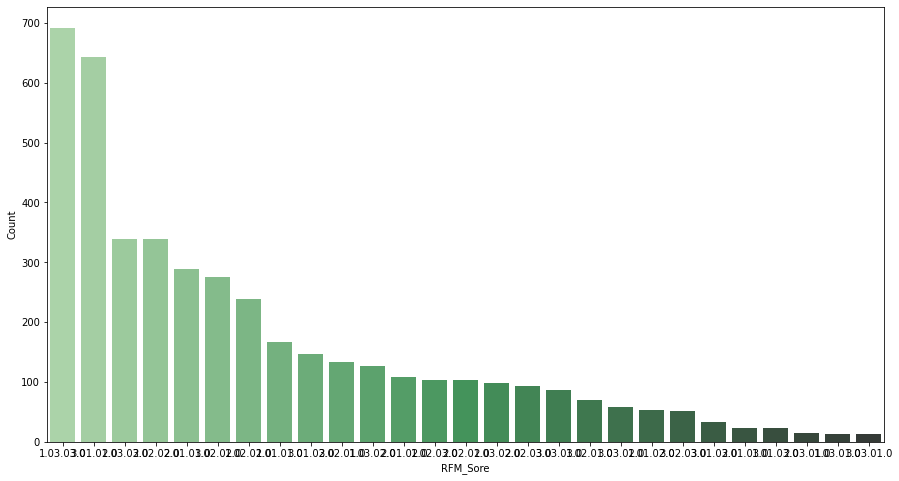

In [38]:
plt.figure(figsize=(15,8))
sns.barplot(data=RFM_count, x='RFM_Sore', y='Count',palette="Greens_d")

In [39]:
def rfm_levels(customers):
  if customers["RFM_Score"]=="313":
    return "Best Customer"
  elif customers["RFM_Score"]=="111":
    return "Lost Cheap Customer"
  elif customers["RFM_Score"]=="133":
    return "Lost Customer"
  elif customers["RFM_Score"]=="233":
    return "Almost Lost Customer"
  elif customers["RFM_Score"]=="311":
    return "New Customers"
  elif customers["F"]==3:
     return "Loyal Customer"
  elif customers["M"]==3:
     return "Big Spender"
  else:
     return "Others"
customers["RFM_Level"] = customers.apply(rfm_levels,axis=1)
customers.iloc[:,6:]

,RFM_Score,RFM_Level
0,3.01.03.0,Big Spender
1,1.03.03.0,Loyal Customer
2,2.02.03.0,Big Spender
3,1.02.03.0,Big Spender
4,3.01.01.0,Others
...,...,...
4334,3.01.01.0,Others
4335,3.01.01.0,Others
4336,1.01.01.0,Others
4337,1.03.03.0,Loyal Customer


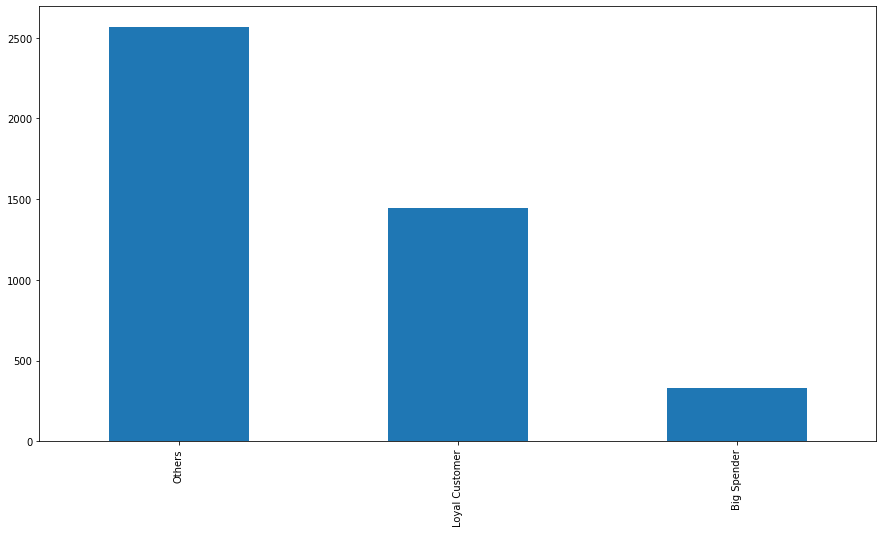

In [40]:
plt.figure(figsize=(15,8))
customers.RFM_Level.value_counts().plot(kind="bar")

In [41]:
customers.query('RFM_Level=="Others"').RFM_Score.value_counts()

3.01.01.0    643
2.02.02.0    339
2.01.01.0    289
3.02.02.0    275
1.02.02.0    238
1.01.01.0    167
3.01.02.0    147
3.02.01.0    134
2.01.02.0    108
2.02.01.0    103
1.02.01.0     70
1.01.02.0     54
Name: RFM_Score, dtype: int64

In [42]:
rfm_level_agg = customers.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': "mean",
    'MonetaryValue': ['mean', 'count']
}).round(2)
rfm_level_agg

Recency Frequency MonetaryValue      
                  mean      mean          mean count
RFM_Level                                           
Big Spender      -0.17     -0.16          0.84   329
Loyal Customer   -0.61      1.09          0.89  1443
Others            0.36     -0.59         -0.61  2567

**RFM Table based on clusters**

In [43]:
customers["Cluster"] = cluster.labels_
customers.groupby("Cluster").agg({
    'Recency': 'mean',
    'Frequency': "mean",
    'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          0.59     -0.69         -0.67  2308
1         -0.67      0.78          0.76  2031

##snake plot

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


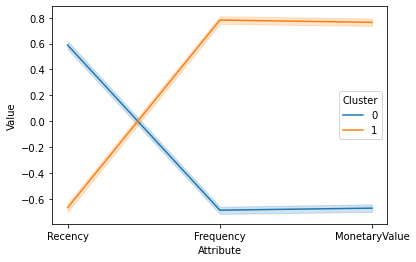

In [44]:
# Create the dataframe
df_normalized = pd.DataFrame(customers, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = cluster.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

##Frequency/Recency Analysis Using the BG/NBD Model from lifetime
- BG/NBD model is available as BetaGeoFitter class in Lifetimes package

In [45]:
pip install lifetimes


In [46]:

from lifetimes.utils import summary_data_from_transaction_data

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='TotalSpend', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [47]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


In [48]:
future_horizon = 10000
data['predicted_purchases'] = bgf.predict(
    future_horizon,
    data['frequency'],
    data['recency'],
    data['T'])
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346,0.0,0.0,325.0,0.000000,20.890131
12347,6.0,365.0,367.0,599.701667,155.547011
12348,3.0,283.0,358.0,301.480000,89.033247
12349,0.0,0.0,18.0,0.000000,94.324297
12350,0.0,0.0,310.0,0.000000,21.715263


In [49]:
#compute the customer alive probability
data['probability_alive'] = bgf.conditional_probability_alive(data["frequency"],data["recency"],data["T"])
data.probability_alive.describe()


count    4339.000000
mean        0.999005
std         0.006941
min         0.716230
25%         0.999272
50%         0.999584
75%         1.000000
max         1.000000
Name: probability_alive, dtype: float64

**Visualizing our Frequency/Recency Matrix**

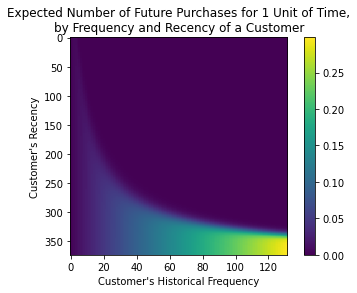

In [50]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

**Visualizing the still alive Matrix**

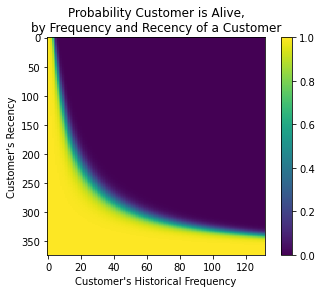

In [51]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [62]:
#predict future transaction for the next 30 days based on historical data
t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])

data['pre_num_txn'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])

data.sort_values(by='predicted_purchases', ascending=False).head(5)


,frequency,recency,T,monetary_value,predicted_purchases,probability_alive,predicted_clv,pre_num_txn
CustomerID,,,,,,,,
14911,131.0,372.0,373.0,1093.661679,9.090383,0.999966,9789.694678,9.090383
12748,113.0,373.0,373.0,298.360885,7.848374,0.999971,2327.861600,7.848374
17841,111.0,372.0,373.0,364.452162,7.710373,0.999962,2786.398562,7.710373
15311,89.0,373.0,373.0,677.729438,6.192362,0.999964,4134.538991,6.192362
14606,88.0,372.0,373.0,135.890114,6.123362,0.999955,846.120615,6.123362


In [ ]:
#predict future transaction for the next 30 days based on historical data
t=30
data["pred_num_txn"] = round(bgf.condit)

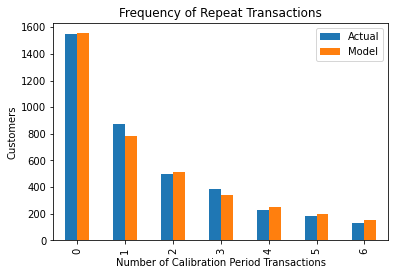

In [53]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [54]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
CustomerID                              ...                                     
12346                 0.0          0.0  ...                0.0             184.0
12347                 2.0        121.0  ...                4.0             184.0
12348                 2.0        110.0  ...                1.0             184.0
12350                 0.0          0.0  ...                0.0             184.0
12352                 3.0         34.0  ...                3.0             184.0

[5 rows x 5 columns]


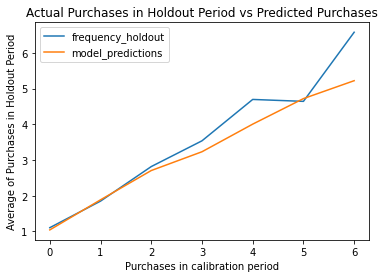

In [55]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

**Estimating customer lifetime value using the Gamma-Gamma model**

In [56]:

returning_customers_summary = data[data['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [57]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [58]:
print(ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value']
    ).head(10))

CustomerID
12347     569.988807
12348     333.762672
12352     376.166864
12356     324.008941
12358     539.930643
12359    1515.282839
12360     652.217077
12362     514.793066
12363     341.147333
12364     282.075487
dtype: float64


In [59]:
#Predicting Customer lifetime value for the next 30 days
data["predicted_clv"] = ggf.customer_lifetime_value(bgf, data["frequency"],
                                                    data["recency"],
                                                    data["T"],
                                                    data["monetary_value"],
                                                    time = 1, #lifetime in months
                                                    freq = "D") #frequency in which the data is present(T)
data.head()                      

,frequency,recency,T,monetary_value,predicted_purchases,probability_alive,predicted_clv
CustomerID,,,,,,,
12346,0.0,0.0,325.0,0.000000,0.002098,1.000000,23.812466
12347,6.0,365.0,367.0,599.701667,0.015656,0.999698,266.276375
12348,3.0,283.0,358.0,301.480000,0.008956,0.999177,88.414076
12349,0.0,0.0,18.0,0.000000,0.009511,1.000000,115.445379
12350,0.0,0.0,310.0,0.000000,0.002181,1.000000,24.773215


In [64]:
#calculating the conditional expected avergae profit for each customer per transaction
data = data[data.monetary_value>0]
data['exp_avg_sales'] = ggf.conditional_expected_average_profit(data["frequency"],
                                                    data["monetary_value"]
                                                   )
data.head()

,frequency,recency,T,monetary_value,predicted_purchases,probability_alive,predicted_clv,pre_num_txn,exp_avg_sales
CustomerID,,,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.471832,0.999698,266.276375,0.471832,569.988807
12348,3.0,283.0,358.0,301.480000,0.267550,0.999177,88.414076,0.267550,333.762672
12352,6.0,260.0,296.0,368.256667,0.565466,0.999405,210.603415,0.565466,376.166864
12356,2.0,303.0,325.0,269.905000,0.212814,0.999478,68.270871,0.212814,324.008941
12358,1.0,149.0,150.0,683.200000,0.247012,0.999486,132.048719,0.247012,539.930643


In [65]:
#checking the expected average value and the actual average value in the data
print(f"Expected average sales: {data.exp_avg_sales.mean()}")
print(f"Actual average sales: {data.monetary_value.mean()}")

Expected average sales: 454.5701345329098
Actual average sales: 477.3586892535673


In [66]:
data["manual_predicted_clv"] = data.pre_num_txn * data.exp_avg_sales
data.head()

,frequency,recency,T,monetary_value,predicted_purchases,probability_alive,predicted_clv,pre_num_txn,exp_avg_sales,manual_predicted_clv
CustomerID,,,,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.471832,0.999698,266.276375,0.471832,569.988807,268.939139
12348,3.0,283.0,358.0,301.480000,0.267550,0.999177,88.414076,0.267550,333.762672,89.298217
12352,6.0,260.0,296.0,368.256667,0.565466,0.999405,210.603415,0.565466,376.166864,212.709449
12356,2.0,303.0,325.0,269.905000,0.212814,0.999478,68.270871,0.212814,324.008941,68.953579
12358,1.0,149.0,150.0,683.200000,0.247012,0.999486,132.048719,0.247012,539.930643,133.369206


In [67]:
print(f"Predicted_clv: {data.predicted_clv.mean()}")
print(f"Manual_Predicted_clv: {data.manual_predicted_clv.mean()}")

Predicted_clv: 241.1082054723455
Manual_Predicted_clv: 243.51928752706826
